In [1]:
import cv2
import numpy as np # this module is useful to work with numerical arrays
import torch
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
from ignite.metrics import SSIM
from skimage.util import img_as_ubyte
import time

VIDEOS_LOCATION = "C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\\videos\\"

transform = transforms.ToTensor()

width = 640
height = 360

entries = []



In [2]:
VIDEOS_LOCATION = "C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\\videos\\"
VIDEOS_TRAIN = [
    {
        "file": "soldiers.mp4",
        "fps": None
    },
    {
        "file": 'running.mp4',
        "fps": None
    }
]

VIDEOS_TEST = [
    {
        "file": 'nato.mp4',
        "fps": None
    }
]

VIDEOS_SKI_TRAIN = [
    {
        "file": 'drone_shot.mp4',
        "fps": None
    },
    {
        "file": "crevace2.mp4",
        "fps": None
    }
]

VIDEOS_SKI_TEST = [
    {
        "file": "powder_maybe2.mp4",
        "fps": None
    }
]

class VideoDataLoader:
    video_index = 0
    videos = None
    cap = None
    frame_batch_buffer = []
    first_frame = None
    def __init__(self, videos):
        self.videos = videos
        self.cap = cv2.VideoCapture(VIDEOS_LOCATION + self.videos[self.video_index]["file"])
        self.videos[self.video_index]["fps"] = self.cap.get(cv2.CAP_PROP_FPS)
        if not self.cap.isOpened():
            print("Error: could not open video file")
        ret, first_frame = self.cap.read()
        for i in range(10):
            ret, middle_frame = self.cap.read()
            if not ret:
                break
            ret, last_frame = self.cap.read()
            if not ret:
                break
            batch_of_frames = [transform(first_frame), transform(middle_frame), transform(last_frame)]
            self.frame_batch_buffer.append(batch_of_frames)
            first_frame = last_frame
        self.first_frame = first_frame

    def reload_buffer(self, videos):
        self.frame_batch_buffer = []
        self.video_index = 0
        self.__init__(videos)

    def hasNext(self):
        return len(self.frame_batch_buffer) != 0

    def nextFile(self):
        self.video_index += 1
        self.cap.release()
        try:
            self.cap = cv2.VideoCapture(VIDEOS_LOCATION + self.videos[self.video_index]["file"])
        except:
            batch = self.frame_batch_buffer.pop(0)
            self.frame_batch_buffer = []
            return batch

        self.videos[self.video_index]["fps"] = self.cap.get(cv2.CAP_PROP_FPS)
        if not self.cap.isOpened():
            print("Error: could not open video file")
        ret, first_frame = self.cap.read()
        for i in range(10):
            ret, middle_frame = self.cap.read()
            if not ret:
                break
            ret, last_frame = self.cap.read()
            if not ret:
                break
            batch_of_frames = [transform(first_frame), transform(middle_frame), transform(last_frame)]
            self.frame_batch_buffer.append(batch_of_frames)
            first_frame = last_frame
        self.first_frame = first_frame
        return self.frame_batch_buffer.pop(0)

    def getNext(self):
        if len(self.frame_batch_buffer) < 5:
            return self.nextFile()
        ret, middle_frame = self.cap.read()
        if not ret:
            return self.nextFile()
        ret, last_frame = self.cap.read()
        if not ret:
            return self.nextFile()

        batch_of_frames = [transform(self.first_frame), transform(middle_frame), transform(last_frame)]
        # batch_of_frames = [self.first_frame, middle_frame, last_frame]
        self.frame_batch_buffer.append(batch_of_frames)
        self.first_frame = last_frame
        # cv2.imshow('batch_of_frames', middle_frame)
        # cv2.imshow('batch_of_frames', last_frame)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     cv2.destroyAllWindows()
        #     self.frame_batch_buffer = []
        return self.frame_batch_buffer.pop(0)


In [3]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.lefthand_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.righthand_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
            # ,
            # nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(True)
        )


    def forward(self, left, right):
        left = self.lefthand_encoder(left)
        right = self.righthand_encoder(right)
        encoded = torch.cat((left, right), 0)
        x = self.decoder(encoded)
        return x


In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results
# torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
autoencoder = Autoencoder()
params_to_optimize = [
    {'params': autoencoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-08)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
autoencoder = autoencoder.to(device)


Selected device: cuda


In [5]:
def testepoch(epoch):
    ssim_metric = SSIM(data_range=1.0)
    videoDataLoader = VideoDataLoader(VIDEOS_TEST)
    videoDataLoader.reload_buffer(VIDEOS_TEST)
    fps = videoDataLoader.videos[0]["fps"]
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    fourcc2 = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter('mark1_video_outs/epoch'+ str(epoch) +'_nato_25vs50fps.avi', fourcc, fps * 2, (width * 2, height), isColor=True)
    out2 = cv2.VideoWriter('mark1_video_outs/epoch'+ str(epoch) +'_nato_12vs25fps.avi', fourcc2, fps, (width * 2, height), isColor=True)
    autoencoder.eval()
    i = 0
    with torch.no_grad():
        test_loss = []
        ssim = []
        while videoDataLoader.hasNext():
            batch = videoDataLoader.getNext()
            first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
            original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

            first_frame = batch[0].to(device)
            middle_frame = batch[1].to(device)
            last_frame = batch[2].to(device)

            res_frame = autoencoder(first_frame, last_frame)
            res_frame1 = autoencoder(first_frame, middle_frame)
            res_frame2 = autoencoder(middle_frame, last_frame)

            middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
            middle_f1 = np.transpose(res_frame1.cpu().data.numpy(), (1, 2, 0))
            middle_f2 = np.transpose(res_frame2.cpu().data.numpy(), (1, 2, 0))
            # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
            # cv2.imshow('generated frame', cv2.hconcat([first_f, middle_f]))
            # if cv2.waitKey(25) & 0xFF == ord('q'):
            #     break

            first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
            middle1_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f1]), 0.0, 1.0))
            middle2_file = img_as_ubyte(np.clip(cv2.hconcat([original_f, original_f]), 0.0, 1.0))
            last_file = img_as_ubyte(np.clip(cv2.hconcat([original_f, middle_f2]), 0.0, 1.0))

            out.write(first_file)
            out.write(middle1_file)
            out.write(middle2_file)
            out.write(last_file)

            middle_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))
            out2.write(first_file)
            out2.write(middle_file)

            # Evaluate loss
            loss = loss_fn(res_frame, middle_frame)
            ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
            ssim_value = ssim_metric.compute()
            ssim.append(ssim_value)

            print('\t %d partial test loss (single batch): %f' % (i, loss.data))
            print('\t %d partial ssim (single batch): %f' % (i, ssim_value))
            i = i + 1
            test_loss.append(loss.detach().cpu().numpy())
        # cv2.destroyAllWindows()
    out.release()
    out2.release()
    return test_loss, ssim

In [6]:
# from torchmetrics import StructuralSimilarityIndexMeasure

# autoencoder.train()

epochs = 5
train_loss_epochs = []
test_loss_epochs = []
ssim_epochs = []
test_ssim_epochs = []
ssim_metric = SSIM(data_range=1.0)
# ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0)
for i in range(epochs):
    autoencoder.train()
    train_loss = []
    ssim = []
    # ssim2 = []
    videoDataLoader = VideoDataLoader(VIDEOS_TRAIN)
    videoDataLoader.reload_buffer(VIDEOS_TRAIN)
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)


        # Encode data
        res_frame = autoencoder(first_frame, last_frame)

        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()


        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()


        # ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        # ssim_value = ssim_metric.compute()
        # ssim.append(ssim_value)

        # res_frame = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        # first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, res_frame]))
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        # Print batch loss
        print('\t %d partial train loss (single batch): %f' % (i, loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    # ssim_epochs.append(ssim)
    # ssim_epochs2.append(ssim2)
    train_loss_epochs.append(train_loss)
    # test_loss, test_ssim = testepoch(i)
    # test_ssim_epochs.append(test_ssim)
    # test_loss_epochs.append(test_loss)
    # cv2.destroyAllWindows()

	 0 partial train loss (single batch): 0.199574
	 0 partial train loss (single batch): 0.198934
	 0 partial train loss (single batch): 0.198613
	 0 partial train loss (single batch): 0.198147
	 0 partial train loss (single batch): 0.197779
	 0 partial train loss (single batch): 0.197244
	 0 partial train loss (single batch): 0.196738
	 0 partial train loss (single batch): 0.196031
	 0 partial train loss (single batch): 0.195335
	 0 partial train loss (single batch): 0.194576
	 0 partial train loss (single batch): 0.194071
	 0 partial train loss (single batch): 0.193299
	 0 partial train loss (single batch): 0.192870
	 0 partial train loss (single batch): 0.192191
	 0 partial train loss (single batch): 0.191629
	 0 partial train loss (single batch): 0.190804
	 0 partial train loss (single batch): 0.190511
	 0 partial train loss (single batch): 0.190015
	 0 partial train loss (single batch): 0.189340
	 0 partial train loss (single batch): 0.188365
	 0 partial train loss (single batch): 0

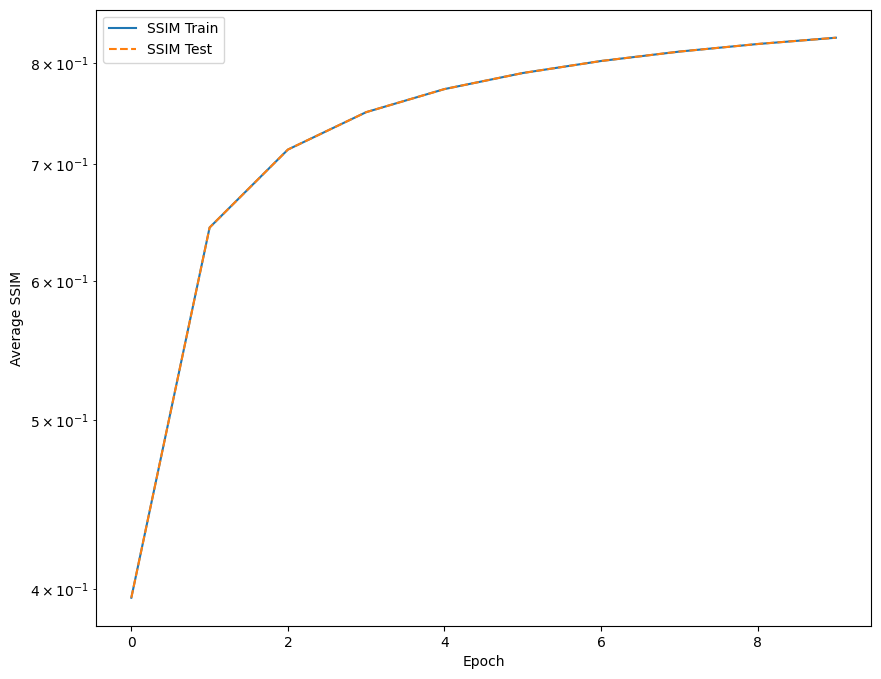

In [9]:
ssim_epochs2 = []
ssim_epochs2_test = []
for ssimepoch in ssim_epochs:
    ssim_epochs2.append(sum(ssimepoch)/len(ssimepoch))
for testssim in test_ssim_epochs:
    ssim_epochs2_test.append(sum(testssim)/len(testssim))
plt.figure(figsize=(10,5))
plt.semilogy(ssim_epochs2, label='SSIM Train')
plt.semilogy(ssim_epochs2, label='SSIM Test', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Average SSIM')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
ssim_epochs2 = []
ssim_epochs2_test = []
for ssimepoch in train_loss_epochs:
    ssim_epochs2.append(sum(ssimepoch)/len(ssimepoch))
for testssim in test_loss_epochs:
    ssim_epochs2_test.append(sum(testssim)/len(testssim))
plt.figure(figsize=(10,5))
plt.semilogy(ssim_epochs2, label='MSE Train')
plt.semilogy(ssim_epochs2, label='MSE Test', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Average MSE')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [10]:
videoDataLoader = VideoDataLoader(VIDEOS_SKI_TEST)
videoDataLoader.reload_buffer(VIDEOS_SKI_TEST)
fps = videoDataLoader.videos[0]["fps"]
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fourcc2 = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('mark1_video_outs/10epochs_ski_30source_60generated.avi', fourcc, fps, (width * 2, height), isColor=True)
out2 = cv2.VideoWriter('mark1_video_outs/10epochs_ski_120fps.avi', fourcc, fps * 2, (width * 2, height), isColor=True)
autoencoder.eval()
i = 0
with torch.no_grad():
    test_loss = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)
        res_frame1 = autoencoder(first_frame, middle_frame)
        res_frame2 = autoencoder(middle_frame, last_frame)
        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        middle_f1 = np.transpose(res_frame1.cpu().data.numpy(), (1, 2, 0))
        middle_f2 = np.transpose(res_frame2.cpu().data.numpy(), (1, 2, 0))

        first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
        middle_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))

        out.write(first_file)
        out.write(middle_file)

        middle_file1 = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f1]), 0.0, 1.0))
        middle_org = img_as_ubyte(np.clip(cv2.hconcat([original_f, original_f]), 0.0, 1.0))
        middle_file2 = img_as_ubyte(np.clip(cv2.hconcat([original_f, middle_f2]), 0.0, 1.0))
        out2.write(first_file)
        out2.write(middle_file1)
        out2.write(middle_org)
        out2.write(middle_file2)


        # cv2.imshow('generated frame', cv2.hconcat([first_f, first_f]))
        # cv2.imshow('generated frame', cv2.hconcat([first_f, middle_f]))
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)

        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1
        test_loss.append(loss.detach().cpu().numpy())
out.release()
out2.release()


	 0 partial test loss (single batch): 0.000625
	 1 partial test loss (single batch): 0.000615
	 2 partial test loss (single batch): 0.000613
	 3 partial test loss (single batch): 0.000621
	 4 partial test loss (single batch): 0.000609
	 5 partial test loss (single batch): 0.000615
	 6 partial test loss (single batch): 0.000607
	 7 partial test loss (single batch): 0.000598
	 8 partial test loss (single batch): 0.000599
	 9 partial test loss (single batch): 0.000598
	 10 partial test loss (single batch): 0.000593
	 11 partial test loss (single batch): 0.000587
	 12 partial test loss (single batch): 0.000590
	 13 partial test loss (single batch): 0.000588
	 14 partial test loss (single batch): 0.000579
	 15 partial test loss (single batch): 0.000594
	 16 partial test loss (single batch): 0.000620
	 17 partial test loss (single batch): 0.000587
	 18 partial test loss (single batch): 0.000628
	 19 partial test loss (single batch): 0.000631
	 20 partial test loss (single batch): 0.000615
	 

In [7]:
videoDataLoader = VideoDataLoader(VIDEOS_SKI_TEST)
videoDataLoader.reload_buffer(VIDEOS_SKI_TEST)
autoencoder.eval()
i = 0

fps = videoDataLoader.videos[0]["fps"]
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
# out = cv2.VideoWriter('mark2_video_outs/5epochs_nn_norm.avi', fourcc, fps/2, (width, height), isColor=True)

with torch.no_grad():
    test_loss = []
    ssim = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(nn.functional.normalize(batch[1]).numpy(), (1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)

        loss = loss_fn(res_frame, middle_frame)
        test_loss.append(loss.detach().cpu().numpy())
        ssim_metric.update((res_frame.unsqueeze(0).cpu(), middle_frame.unsqueeze(0).cpu()))
        ssim_value = ssim_metric.compute()
        ssim.append(ssim_value)

        # res_frame = nn.functional.normalize(res_frame)
        #
        # # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        # middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        #
        #
        # middle_file = img_as_ubyte(np.abs(original_f - middle_f))
        # mini = np.min(middle_file)
        # maxi = np.max(middle_file)
        # middle_file = (middle_file-mini)/(maxi-mini)
        # out.write(middle_file)


        # cv2.imshow('generated frame', middle_file)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1

# cv2.destroyAllWindows()
# out.release()

	 0 partial test loss (single batch): 0.000740
	 1 partial test loss (single batch): 0.000729
	 2 partial test loss (single batch): 0.000727
	 3 partial test loss (single batch): 0.000735
	 4 partial test loss (single batch): 0.000725
	 5 partial test loss (single batch): 0.000728
	 6 partial test loss (single batch): 0.000721
	 7 partial test loss (single batch): 0.000712
	 8 partial test loss (single batch): 0.000714
	 9 partial test loss (single batch): 0.000711
	 10 partial test loss (single batch): 0.000704
	 11 partial test loss (single batch): 0.000696
	 12 partial test loss (single batch): 0.000696
	 13 partial test loss (single batch): 0.000692
	 14 partial test loss (single batch): 0.000683
	 15 partial test loss (single batch): 0.000702
	 16 partial test loss (single batch): 0.000731
	 17 partial test loss (single batch): 0.000699
	 18 partial test loss (single batch): 0.000739
	 19 partial test loss (single batch): 0.000744
	 20 partial test loss (single batch): 0.000726
	 

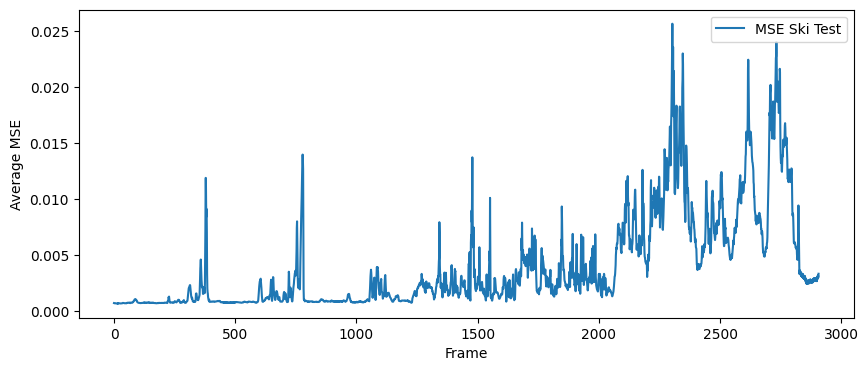

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(test_loss, label='MSE Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average MSE')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

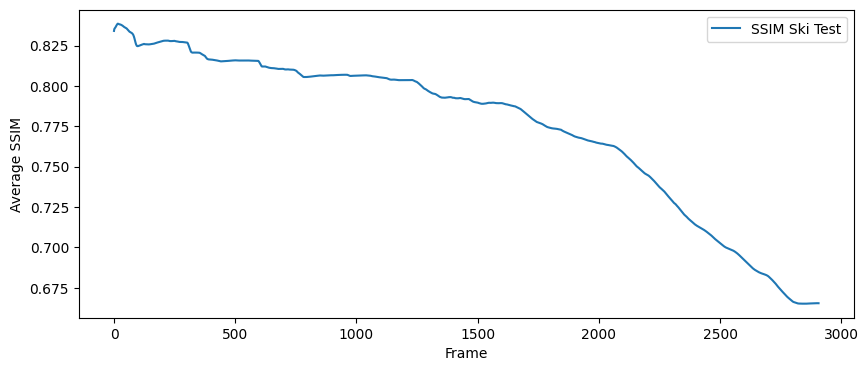

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(ssim, label='SSIM Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average SSIM')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

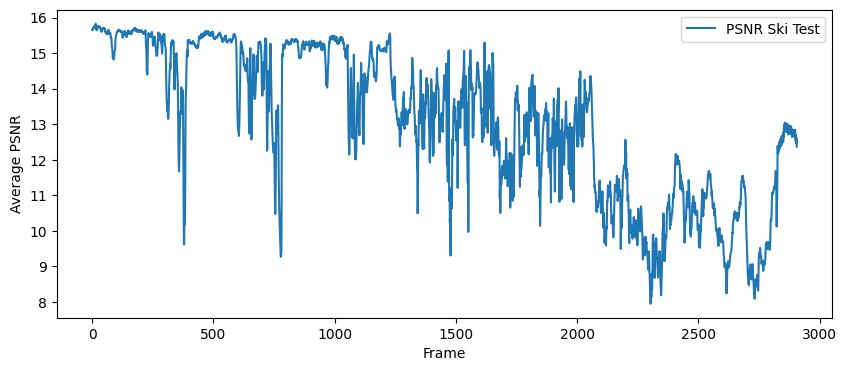

In [17]:
import math
psnr = []
for err in test_loss:
    psnr.append(10 * math.log10(1.0 / math.sqrt(err)))
plt.figure(figsize=(10, 4))
plt.plot(psnr, label='PSNR Ski Test')
plt.xlabel('Frame')
plt.ylabel('Average PSNR')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [1]:
videoDataLoader = VideoDataLoader(VIDEOS_SKI_TEST)
videoDataLoader.reload_buffer(VIDEOS_SKI_TEST)
autoencoder.eval()
i = 0
with torch.no_grad():
    test_loss = []
    while videoDataLoader.hasNext():
        batch = videoDataLoader.getNext()
        first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
        original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        res_frame = autoencoder(first_frame, last_frame)
        res_frame1 = autoencoder(first_frame, middle_frame)
        res_frame2 = autoencoder(middle_frame, last_frame)
        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
        middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
        middle_f1 = np.transpose(res_frame1.cpu().data.numpy(), (1, 2, 0))
        middle_f2 = np.transpose(res_frame2.cpu().data.numpy(), (1, 2, 0))

        first_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, first_f]), 0.0, 1.0))
        middle_file = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f]), 0.0, 1.0))


        middle_file1 = img_as_ubyte(np.clip(cv2.hconcat([first_f, middle_f1]), 0.0, 1.0))
        middle_org = img_as_ubyte(np.clip(cv2.hconcat([original_f, original_f]), 0.0, 1.0))
        middle_file2 = img_as_ubyte(np.clip(cv2.hconcat([original_f, middle_f2]), 0.0, 1.0))

        cv2.imshow('generated frame', cv2.hconcat([np.abs(original_f - middle_f)]))
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)

        print('\t %d partial test loss (single batch): %f' % (i, loss.data))
        i = i + 1
        test_loss.append(loss.detach().cpu().numpy())
cv2.destroyAllWindows()

NameError: name 'VideoDataLoader' is not defined